# **Lecture 4: Classification and Logistic Regression**

Next, we turn our attention to another important task in supervised learning---classification. We define this problem and introduce a first set of algorithms.

# 4.1. Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.
We distinguish between two types of supervised learning problems depending on the value of targets $y^{(i)}$. 

1. __Regression__: The target variable $y \in \mathcal{Y}$ is continuous:  $\mathcal{Y} \subseteq \mathbb{R}$.

2. __Classification__: The target variable $y$ is discrete and takes one of $K$ possible values:  $\mathcal{Y} = \{y_1, y_2, \ldots y_K\}$. Each discrete value corresponds to a *class* that we want to predict.

An important special case of classification is when the number of classes $K=2$.
In this case, we have an instance of a *binary classification* problem.

## 4.1.1. A Classification Dataset: Iris Flowers

To introduce our first example of a classification problem, we will use a new dataset. 
This famous dataset was originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936 and contains measurements collected from three types of iris flowers. 
<!-- Nowadays, it's widely used for demonstrating machine learning algorithms. -->

We will load this dataset from `scikit-learn`. It comes with a useful description, which we print out.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import warnings
warnings.filterwarnings('ignore')

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Let's print the first 5 rows of this dataset.

In [2]:
# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

## 4.1.2. Understanding Classification

Our goal will be to perform classification of Iris flowers. How is this classification task different from regression?
* In regression, our goal is to fit a curve through space that passes close to the set of targets $y^{(i)}$.

* In classification, classes are associated with regions of the feature space, and our goal is to find the boundaries that separate these regions.

Let's illustrate this distinction by visualizing the output of a classification algorithm on our dataset. We start by importing `matplotlib` and other plotting tools.

In [3]:
# Code from: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

Here is a visualization of this dataset in 2D. Note that we are only using the first 2 attributes (out of 4) for each flower.

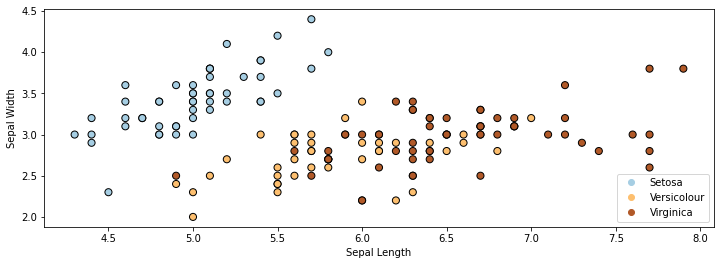

In [5]:
plt.rcParams['figure.figsize'] = [12, 4]
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y,
            edgecolor='k', s=50, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right')

In the above figure, each dot represents a flower. Each flower's coordinates in 2D space are determined by the height and width of its sepals.

Let's train a classification algorithm on this data. We will use the `LogisticRegression` method in `sklearn`.

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)

# Create an instance of Logistic Regression Classifier and fit the data.
X = iris_X.to_numpy()[:,:2]
# rename class two to class one
Y = iris_y.copy()
logreg.fit(X, Y) 

LogisticRegression(C=100000.0)

The figure below visualizes the regions predicted by `LogisticRegression` to be associated with the blue, brown, and yellow classes. The lines between them are the decision boundaries.

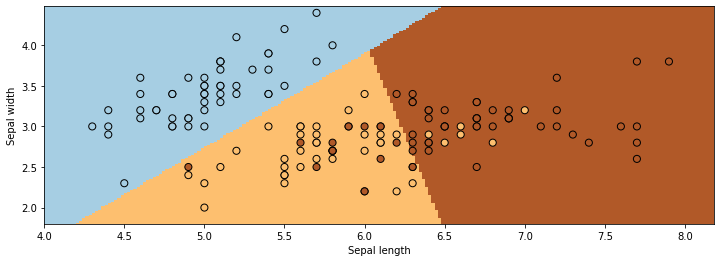

In [7]:
xx, yy = np.meshgrid(np.arange(4, 8.2, .02), np.arange(1.8, 4.5, .02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=50)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

As you can see, classification can be viewed as discovering partitions of the input space associated with each class.

# 4.2. Logistic Regression

The previous classification example used an algorithm called logistic regression. In the rest of this lecture, we are going to derive this algorithm from scratch.

Note that although this algorithm is called logistic *regression*, it is actually a *classification* algorithm. This is an unfortunate misnomer.

## 4.2.1. Binary Classification and the Iris Dataset

We will to start by looking at binary (two-class) classification. 
To keep things simple, we will use the Iris dataset. We will attempt to distinguish class 0 (Iris Setosa) from the other two classes.

We only use the first two features in the dataset. Our task is to tell apart Setosa flowers from non-Setosa flowers. Visualizing the dataset in 2D yields the figure below.

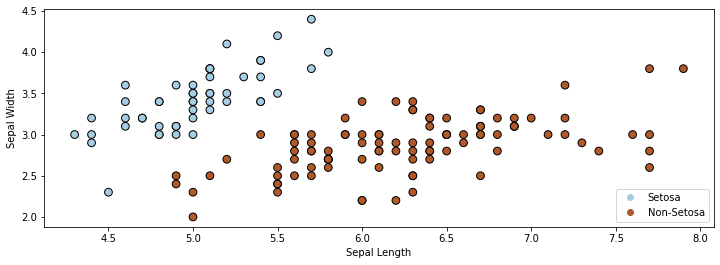

In [9]:
# rename class two to class one
iris_y2 = iris_y.copy()
iris_y2[iris_y2==2] = 1

# Plot also the training points
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y2,
            edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Non-Setosa'], loc='lower right')

## 4.2.2. A First Attempt At Classification Using Least Squares

Recall that the linear regression algorithm fits a linear model of the form

$$ 
f(x) = \sum_{j=0}^d \theta_j \cdot x_j = \theta^\top x. 
$$

It minimizes the mean squared error (MSE)

$$
J(\theta)= \frac{1}{2n} \sum_{i=1}^n(y^{(i)}-\theta^\top x^{(i)})^2
$$

on a dataset $\{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We could use least squares to solve our classification problem, setting $\mathcal{Y} = \{0, 1\}$.

In [16]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html   
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

# Fit the data.
X = iris_X.to_numpy()[:,:2]
Y = iris_y2
linreg.fit(X, Y)

LinearRegression()

Ordinary least squares returns a decision boundary that is not unreasonable.

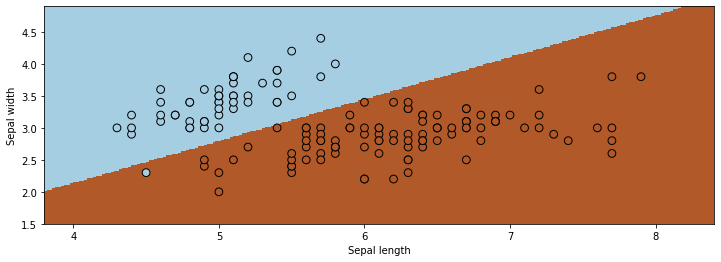

In [17]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = linreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z[Z>0.5] = 1
Z[Z<0.5] = 0

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired, s=60)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

However, applying ordinary least squares is problematic for a few reasons.

* There is nothing to prevent outputs larger than one or smaller than zero, which is conceptually wrong.
* We also don't have optimal performance: at least one point is misclassified, and others are too close to the decision boundary.

## 4.2.3. The Logistic Function

To address the fact that the output of linear regression is not in $[0,1]$, we will instead attempt to *squeeze* it into that range using

$$ 
\sigma(z) = \frac{1}{1 + \exp(-z)}. 
$$

This is known as the *sigmoid* or *logistic* function.

The logistic function $\sigma : \mathbb{R} \to [0,1]$ "squeezes" points from the real line into $[0,1]$.

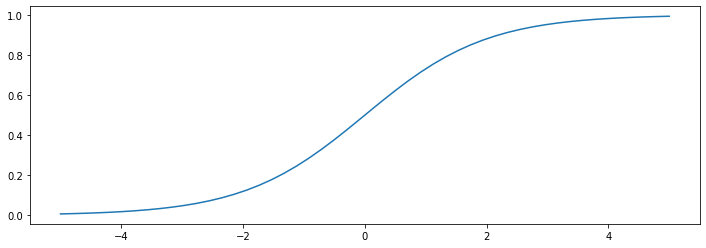

In [11]:
import numpy as np
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1+np.exp(-z))

z = np.linspace(-5, 5)
plt.plot(z, sigmoid(z))

A few observations about the logistic function:

* The function tends to 1 as $z \to \infty$ and tends to 0 as $z \to -\infty$.

* Thus, models of the form $\sigma(\theta^\top x)$ output values between 0 and 1, which is suitable for binary classification.

* It is easy to show that the derivative of $\sigma(z)$ has a simple form:
$\frac{d\sigma}{dz} = \sigma(z)(1-\sigma(z)).$

## 4.2.4. A Model Family for Logistic Regression 

Next, we will use the logistic function to define our first classification algorithm---logistic regression.

We will start by defining the model class for this algorithm. Later on we will also define the objective and the optimizer.

### A Model Class

Logistic regression is a classification algorithm which uses a model $f_\theta$ of the form

$$ 
f_\theta(x) = \sigma(\theta^\top x) = \frac{1}{1 + \exp(-\theta^\top x)}.
$$

Note that we effectively start with a linear model like in ordinary least squares and then "squeeze" its output to be in $[0,1]$ using the logistic function.

Note also that logistic regression is actually a binary __classification__ algorithm.
The term *regression* is an unfortunate historical misnomer.

Let's implement a logistic regression model in `numpy`.

In [12]:
def f(X, theta):
    """The sigmoid model we are trying to fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional data matrix
    
    Returns:
    y_pred (np.array): n-dimensional vector of predicted targets
    """
    return sigmoid(X.dot(theta))

Currently, this model is not very useful---we need to use it with a good set of weights `theta`. We will shortly explain how to find good `theta`.

### Probabilistic Interpretations

Interestingly, the logistic model can also be interpreted as outputing a class membership probability. Specifically, the model defines a conditional probability $P_\theta(y|x)$ distribution as follows:

$$
\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}
$$

Recall that a probability over $y\in \{0,1\}$ is called Bernoulli.

We will use this probabilistic interpretation to define an objective for logistic regression.

# 4.3. Maximum Likelihood

Training a logistic regression model requires defining a learning objective.
We will derive this objective by first introducing a general principle for training machine learning models---the principle of maximum likelihood.

## 4.3.1. Probabilistic Models

The supervised models we have seen so far parameterize a function

$$ 
f_\theta : \mathcal{X} \to \mathcal{Y} 
$$

that maps inputs $x \in \mathcal{X}$ to targets $y \in \mathcal{Y}$. Models have *parameters* $\theta \in \Theta$ living in a set $\Theta$.

### Probabilistic Machine Learning Models

A supervised model could also parameterize a *probability distribution* $P_\theta(y|x)$ that maps inputs $x$ to a distribution over targets $y$. 
Concretely, this means defining a formula with parameters $\theta$ that given an $x, y$ yields a probability in $[0,1]$. 

Many supervised learning models can be interpreted as defining probabilities. The logistic regression model was our first example of a parameterization of $P_\theta(y|x)$. Later, we will also see examples of models that parameterize a joint probability $P_\theta(x,y)$ of an input-target pair $(x,y)$. 

For example, our logistic model defines ("parameterizes") a probability distribution $P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]$ as follows:

$$
\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}
$$


###  More Examples

What are some other ways to define a distribution $P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]$?

* We start with an input $x$, and we pass it to a function $f$.
* $f(x)$ outputs the parameters $\mu(x), \Sigma(x)$ of a Gaussian distribution over $y$.
* The distribution $P(y; \mu(x), \Sigma(x))$ is Gaussian with mean and variance $\mu(x), \Sigma(x)$.

Interestingly, the ordinary least squares algorithm can be interpreted as doing precisely this (with a fixed $\Sigma(x)=1$). See below for details.

More generally, the following recipe is common:

* We start with an input $x$, and we pass it to a function $f$. Normally $f(x)$ returns $y'$, an estimate for the target.
* Alternatively, $f$ could output a parameter $\psi(x)$ for a distribution over $y$ (Gaussian, Bernoulli, Poisson, etc.)
* The distribution $P(y; \psi(x))$ is a probability over $y$ parameterized by $\psi(x)$.


## 4.3.2. Maximum Likelihood

Maximum likelihood is a general principle for deriving a training objective for any model that has a probabilistic interpretation.

### Conditional Maximum Likelihood

We can train any model that defines a probability distribution $P_\theta(y|x)$ by optimizing
the *conditional maximum likelihood* objective

$$
L(\theta) = \prod_{i=1}^n P_\theta(y^{(i)}|{x}^{(i)})
$$

defined over a dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

Maximizing $L(\theta)$ asks that for each input $x^{(i)}$ in the dataset $\mathcal{D}$, $P_\theta$ should assign a high probability to the correct target $y^{(i)}$.

#### From Likelihood to Log-Likelihood

A lot of mathematical derivations and numerical calculations become simpler if we instead maximize the log of the likelihood:

$$
\begin{align*}
\ell(\theta) = \log L(\theta) & = \log \prod_{i=1}^n P_\theta(y^{(i)} | {x}^{(i)}) = \sum_{i=1}^n \log P_\theta(y^{(i)} | {x}^{(i)}).
\end{align*}
$$

Note that since the log is a monotonically increasing function, it doesn't change the optimal $\theta$.

Finally, we may want to take the average log-likelihood instead of the sum. This gives us the following learning principle, known as *maximum log-likelihood*:

$$
\max_\theta \ell(\theta) = \max_{\theta} \frac{1}{n}\sum_{i=1}^n \log P_\theta(y^{(i)} | {x}^{(i)}).
$$

### Intuitions for Maximum Likelihood

Why is maximum likelihood a good objective?  Given $x^{(i)}$, our model defines a distribution $P_\theta(y|x^{(i)})$ over $y$
 We want to choose the weights such that the true label $y^{(i)}$ has the highest possible probability at each known $x^{(i)}$

Recall our earlier example with logistic regression.

* The model defines a probability $P_\theta(y=1 | x^{(i)})  = \sigma(\theta^\top x)$ for each $x^{(i)}$.
* The principle of maximum likelihood says that we should maximize this value, i.e. $\sigma(\theta^\top x^{(i)})$ should be large when $y^{(i)}=1$
* But $\sigma(\theta^\top x^{(i)})$ is the output of $f_\theta(x^{(i)})$---hence maximum likelihood asks the model $f_\theta(x) = \sigma(\theta^\top x)$ to output values close to one when the true label is one.
* Similarly, when $y^{(i)}=0$, maximum likelihood asks $1-\sigma(\theta^\top x^{(i)})$ to be large, hence $\sigma(\theta^\top x^{(i)})$ will be small, and thus $f_\theta(x^{(i)})$ will be close to zero when the true label is zero.

### Maximum Likelihood

More generally, we can train any model that defines a probability distribution $P_\theta(x,y)$ by optimizing
the *maximum likelihood* objective

$$
L(\theta) = \prod_{i=1}^n P_\theta({x}^{(i)}, y^{(i)})
$$

defined over a dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.


The principle of maximum likelihood says that we should find model parameters $\theta$ that yield high likelihood.

In other words, this means that we want to find $\theta$ such that the training dataset $\mathcal{D}$ has a high probability under the probability distribution $P_\theta$ induced by the model. To put it differently, the model $P_\theta$ is likely to have generated the data.

As before, it is often simpler to work with log-probabilities. Taking the logs and performing the same analysis as earlier, we obtain the following learning principle, known as *maximum log-likelihood*:

$$
\max_\theta \ell(\theta) = \max_{\theta} \frac{1}{n}\sum_{i=1}^n \log P_\theta({x}^{(i)}, y^{(i)}).
$$

### Example: Flipping a Random Coin

To better understand the principle of maximum likelihood, consider a simple example in which we repeatedly toss a biased coin and record the outcomes.

* There are two possible outcomes: heads ($H$) and tails ($T$). A training dataset consists of tosses of a biased coin, e.g., $\mathcal{D}=\{H,H,T,H,T\}$ 

* Our task is to estimiate the true probability $\theta$ of the coin falling heads.

How should we choose $\theta$ if 3 out of 5 tosses are heads? Let's apply maximum likelihood learning.

* Our dataset is $\mathcal{D}=\{x^{(1)},x^{(2)},x^{(3)},x^{(4)},x^{(5)}\}=\{H,H,T,H,T\}$ 
* Our model is $P_\theta(x)=\theta$ if $x=H$ and $P_\theta(x)=1-\theta$ if $x=T$, and there is a single parameter $\theta \in [0,1]$
* The likelihood of the data under this model is $L(\theta) = \prod_{i=1}^n P_\theta(x^{(i)})=\theta \cdot \theta \cdot (1-\theta) \cdot \theta \cdot (1-\theta)$.

We optimize for $\theta$ which makes $\mathcal{D}$ most likely. What is the solution in this case? Let's plot the value of the likelihood as a function of $\theta$.

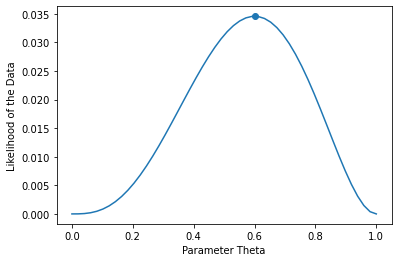

In [12]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# our dataset is {H, H, T, H, T}; if theta = P(x=H), we get:
coin_likelihood = lambda theta: theta*theta*(1-theta)*theta*(1-theta)

theta_vals = np.linspace(0,1)
plt.ylabel('Likelihood of the Data')
plt.xlabel('Parameter Theta')
plt.scatter([0.6], [coin_likelihood(0.6)])
plt.plot(theta_vals, coin_likelihood(theta_vals))

The likelihood $L(\theta)$ is maximized by $\theta=0.6$, which is also what we expect intuitively since 3/5 tosses are heads.

###  A Formula For Coin Flips Using Maximum Likelihood

We can also find the same solution by optimizing the log-likelihood analytically. The formula equals:

$$
\begin{aligned}
L(\theta) & =\theta^{\# \text { heads }} \cdot(1-\theta)^{\# \text { tails }} \\
\log L(\theta) & =\log \left(\theta^{\# \text { heads }} \cdot(1-\theta)^{\# \text { tails }}\right) \\
& =\# \text { heads } \cdot \log (\theta)+\# \text { tails } \cdot \log (1-\theta)
\end{aligned}
$$

The maximum likelihood estimate is the $\theta^* \in [0,1]$ such that $\log L(\theta^*)$ is maximized.

Differentiating the log-likelihood function with respect to $\theta$ and setting the derivative to zero, we obtain

$$
\theta^*= \frac{\#\,\text{heads}}{\#\,\text{heads}+\#\,\text{tails}}
$$


When exact solutions are not available, we can optimize the log likelihood numerically, e.g. using gradient descent.

# 4.4. Learning a Logistic Regression Model

Next, we will use maximum likelihood to learn the parameters of a logistic regression model.
Recall that a logistic model defines ("parameterizes") a probability distribution $P_\theta(y|x) : \mathcal{X} \times \mathcal{Y} \to [0,1]$ as follows:

$$
\begin{align*}
P_\theta(y=1 | x) & = \sigma(\theta^\top x) \\
P_\theta(y=0 | x) & = 1-\sigma(\theta^\top x).
\end{align*}
$$

When $y \in \{0,1\}$, can write this more compactly as

$$
\begin{align*}
P_\theta(y | x) = \sigma(\theta^\top x)^y \cdot (1-\sigma(\theta^\top x))^{1-y}
\end{align*}
$$

## 4.4.1. Defining an Objective for Logistic Regression Using Maximum Likelihood

We want to maximized the maximum likelihood over a binary classification dataset  $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

$$
\begin{align*}
\ell(\theta) & = \frac{1}{n}\sum_{i=1}^n \log P_\theta (y^{(i)} \mid x^{(i)}) \\
& = \frac{1}{n}\sum_{i=1}^n \log \sigma(\theta^\top x^{(i)})^{y^{(i)}} \cdot (1-\sigma(\theta^\top x^{(i)}))^{1-y^{(i)}} \\
& = \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \cdot \log \sigma(\theta^\top x^{(i)}) + (1-y^{(i)}) \cdot \log (1-\sigma(\theta^\top x^{(i)})).
\end{align*}
$$

This objective is also often called the log-loss, or cross-entropy.

Observe that this objective asks the model to output a large score $\sigma(\theta^\top x^{(i)})$ (a score that's close to one) if $y^{(i)}=1$, and a score that's small (close to zero) if $y^{(i)}=0$.

Let's implement the log-likelihood objective.

In [13]:
def log_likelihood(theta, X, y):
    """The cost function, J(theta0, theta1) describing the goodness of fit.
    
    We added the 1e-6 term in order to avoid overflow (inf and -inf).
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return (y*np.log(f(X, theta) + 1e-6) + (1-y)*np.log(1-f(X, theta) + 1e-6)).mean()

## 4.4.2. Optimizing the Logistic Regression Objective Using Gradient Descent

We still need an optimizer for the maximum likelihood.
Unfortunately, there is no simple analytic formula like that for OLS.
Therefore, we will instead rely on gradient descent.

### 4.4.2.1. Gradient of the Log-Likelihood

We want to use gradient descent to maximize the log-likelihood, hence our objective is
$J(\theta) = - \ell(\theta).$

We can show that the gradient of the negative log-likelihood equals:

$$
\begin{align*}
\nabla_\theta J (\theta) =  \nabla_\theta \left[-\ell (\theta) \right]= 
\left( \sigma(\theta^\top x) - y \right) \cdot \bf{x}.
\end{align*}
$$

Interestingly, this expression looks similar to the gradient of the mean squared error, which we derived in the previous lecture.

Let's implement the gradient.

In [14]:
def loglik_gradient(theta, X, y):
    """The cost function, J(theta0, theta1) describing the goodness of fit.
    
    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    
    Returns:
    grad (np.array): d-dimensional gradient of the MSE
    """
    return np.mean((f(X, theta)-y) * X.T, axis=1)

### 4.4.2.2. Gradient Descent

Recall, that if we want to minimize an objective $J(\theta)$, we may start with an initial guess $\theta_0$ for the parameters and repeat the following update:

$$ 
\theta_i := \theta_{i-1} - \alpha \cdot \nabla_\theta J(\theta_{i-1}). 
$$

Let's now implement gradient descent.

In [15]:
threshold = 5e-5
step_size = 1e-1

theta, theta_prev = np.zeros((3,)), np.ones((3,))
opt_pts = [theta]
opt_grads = []
iter = 0
iris_X['one'] = 1
X_train = iris_X.iloc[:,[0,1,-1]].to_numpy()
y_train = iris_y2.to_numpy()

while np.linalg.norm(theta - theta_prev) > threshold:
    if iter % 50000 == 0:
        print('Iteration %d. Log-likelihood: %.6f' % (iter, log_likelihood(theta, X_train, y_train)))
    # the next three lines are the main part of gradient descent
    theta_prev = theta
    gradient = loglik_gradient(theta, X_train, y_train)
    theta = theta_prev - step_size * gradient
    # below, we also save the points visited by gradient descent
    opt_pts += [theta]
    opt_grads += [gradient]
    iter += 1

Iteration 0. Log-likelihood: -0.693145
Iteration 50000. Log-likelihood: -0.021506
Iteration 100000. Log-likelihood: -0.015329
Iteration 150000. Log-likelihood: -0.012062
Iteration 200000. Log-likelihood: -0.010076


Let's now visualize the result.

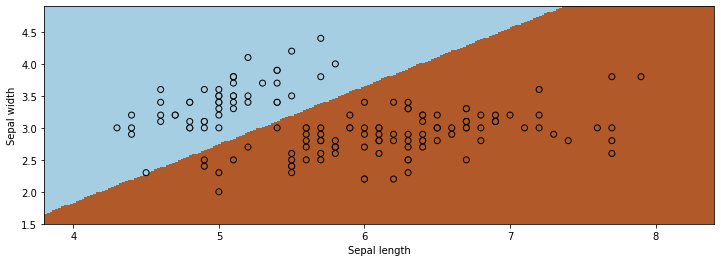

In [16]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = f(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape)], theta)
Z[Z<0.5] = 0
Z[Z>=0.5] = 1

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

This is how we would use the algorithm via `sklearn`.

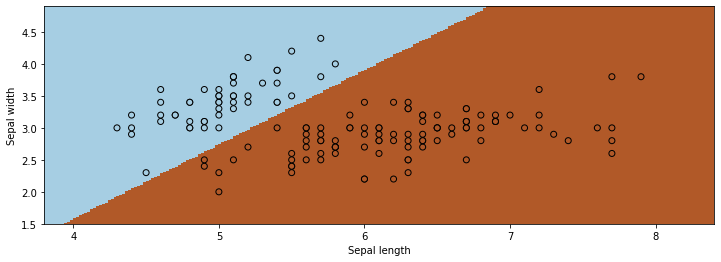

In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, fit_intercept=True)

# Create an instance of Logistic Regression Classifier and fit the data.
X = iris_X.to_numpy()[:,:2]
Y = iris_y2
logreg.fit(X, Y)

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, .02))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

We see that both algorithms give us similar results!

## 4.4.3. Algorithm: Logistic Regression 

We have now fully defined our first classificaiton algorithm---logistic regression. We summarize its key components below.

* __Algorithm Type__: Supervised learning (binary classification)
* __Model family__: Linear decision boundaries.
* __Objective function__: Cross-entropy, a special case of log-likelihood.
* __Optimizer__: Gradient descent.
* __Probabilistic interpretation__: Parametrized Bernoulli distribution.

### Additional Observations About Logistic Regression

Note that logistic regression finds a linear decision boundary. This is the set of points for which $P(y=1|x)=P(y=0|x)$, or equivalently:

$$
\begin{align*}
0 = \log\frac{P(y=1|x)}{P(y=0|x)}
= \log \frac{\frac{1}{1+\exp(-\theta^\top x)}}{1-\frac{1}{1+\exp(-\theta^\top x)}}
= \theta^\top x
\end{align*}
$$

The set of $x$ for which $0=\theta^\top x$ is a linear surface.

Unlike least squares, we don't have a closed form solution (a formula) for the optimal $\theta$. We can nonetheless find it numerically via gradient descent.

# 4.5. Softmax Regression for Multi-Class Classification

Finally, let's look at an extension of logistic regression to an arbitrary number of classes.

## 4.5.1. Multi-Class Classification

Logistic regression only applies to binary classification problems. What if we have an arbitrary number of classes $K$?

* The simplest approach that can be used with any machine learning algorithm is the "one vs. all" approach. We train one classifer for each class to distinguish that class from all the others. 

* This works, but is not very elegant. Alternatively, we may fit a probabilistic model that outputs multi-class probabilities.

Let's load a fully multiclass version of the Iris dataset.

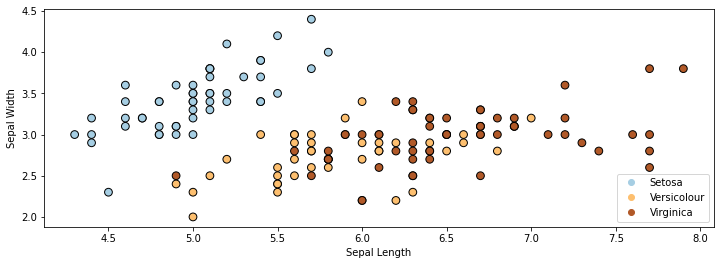

In [18]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# Plot also the training points
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y,
            edgecolor='k', s=60, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica'], loc='lower right')

## 4.5.2. The Softmax Function

The logistic function $\sigma : \mathbb{R} \to [0,1]$ "squeezes" the score $z\in\mathbb{R}$ of a class into a probability in $[0,1]$.

The *softmax* function $\vec \sigma : \mathbb{R}^K \to [0,1]^K$ is a multi-class version of $\sigma$ 
* It takes in a $K$-dimensional *vector* of class scores $\vec z\in\mathbb{R}$ 
* It "squeezes" $\vec z$ into a length $K$ *vector* of  probabilities in $[0,1]^K$

The $k$-th component of the output of the softmax function $\vec \sigma$ is defined as

$$ 
\sigma(\vec z)_k = \frac{\exp(z_k)}{\sum_{l=1}^K \exp(z_l)}. 
$$

In other words, the softmax function takes a vector of scores $\vec z$, exponentiates each score $z_k$, and normalizes the exponentiated scores such that they sum to one.

When $K=2$, this function takes the following form:

$$ 
\sigma(\vec z)_1 = \frac{\exp(z_1)}{\exp(z_1) + \exp(z_2)}. 
$$

Observe that adding a constant $c \in \mathbb{R}$ to each score $z_k$ doesn't change the output of softmax, e.g.:

$$ 
\frac{\exp(z_1)}{\exp(z_1) + \exp(z_2)} = \frac{\exp(z_1+c)}{\exp(z_1+c) + \exp(z_2+c)}. 
$$

Thus, without loss of generality, we can assume $z_1=0$. For any $\vec z = (z_1, z_2)$, we can define $\vec z' = (0, z_2') = (0, z_2-z_1)$ such that $\vec\sigma(\vec z) = \vec\sigma(\vec z')$. Assuming $z_1=0$ doesn't change the probabilities that $\vec\sigma$ can output.

Assuming that $z_1 =0$ means that $\exp(z_1) = 1$ and softmax becomes

$$ 
\sigma(\vec z)_1 = \frac{1}{1 + \exp(z_2)}. 
$$

This is effectively our sigmoid function. Hence softmax generalizes the sigmoid function.

## 4.5.3. Softmax Regression

We will now use the softmax function to define a generalization of logistic regression to multi-class classification. The resulting algorithm is called softmax regression.

### 4.5.3.1. Softmax Regression: Model Class

Softmax regression is a multi-class classification algorithm which uses a model $f_\theta : \mathcal{X} \to [0,1]^K$ that generalizes logistic regression.

Softmax regression works as follows:
1. Given an input $x$, we compute $K$ scores, one per class. The score 

$$
z_k = \theta_k^\top x
$$

of class $k$ is a linear function of $x$ and parameters $\theta_k$ for class $k$

2. We "squeeze" the vector of scores $\vec z$ into $[0,1]^K$ using the softmax function $\vec\sigma$ and we output $\vec\sigma(\vec z)$, a vector of $K$ probabilities.

The parameters of this model are $\theta = (\theta_1, \theta_2, ..., \theta_K)$, and the parameter space is $\Theta = \mathbb{R}^{K \times d}$.

The output of the model is a *vector* of class membership probabilities, whose $k$-th component is

$$ 
\sigma(\theta_k^\top x)_k = \frac{\exp(\theta_k^\top x)}{\sum_{l=1}^K \exp(\theta_l^\top x)}, 
$$

where each $\theta_l \in \mathbb{R}^d$  is the vector of parameters for class $\ell$ and $\theta = (\theta_1, \theta_2, ..., \theta_K)$.

As before, we can assume without loss of generality that $z_1=0$ (or equivalently that $\theta_1=0$). This doesn't change the set of functions $\mathcal{X} \to [0,1]^K$ that our model class can represent.

Note again that softmax regression is actually a __classification__ algorithm.
The term *regression* is an unfortunate historical misnomer.

### 4.5.3.2. Softmax Regression: Learning Objective and Optimizer

The softmax model outputs a vector of probabilities, and defines a conditional probability distribution as follows:

$$
\begin{align*}
P_\theta(y=k | x) & = \vec\sigma(\vec z)_k =\frac{\exp(\theta_k^\top x)}{\sum_{l=1}^K \exp(\theta_l^\top x)}.
\end{align*}
$$

Recall that a probability over $y\in \{1,2,...,K\}$ is called Categorical.

Thus, we may maximize the likelihood of this model over a dataset  $\mathcal{D}$.

$$
\begin{align*}
L(\theta) & = \prod_{i=1}^n P_\theta (y^{(i)} \mid x^{(i)}) = \prod_{i=1}^n \vec \sigma(\vec z^{(i)})_{y^{(i)}} \\
& = \prod_{i=1}^n \left( \frac{\exp(\theta_{y^{(i)}}^\top x^{(i)})}{\sum_{l=1}^K \exp(\theta_l^\top x^{(i)})} \right). \\
\end{align*}
$$

We optimize this using gradient descent.

Let's now apply softmax regression to the Iris dataset by using the implementation from `sklearn`.

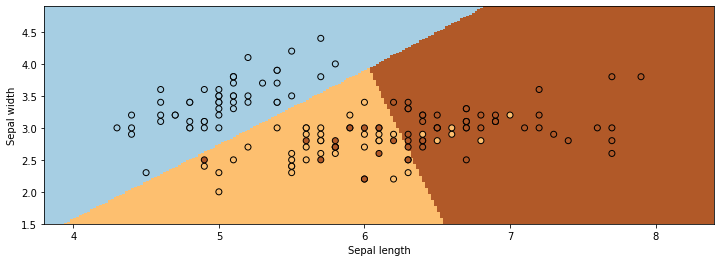

In [19]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5, multi_class='multinomial')

# Create an instance of Softmax and fit the data.
logreg.fit(X, iris_y)
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

### 4.5.3.3. Algorithm: Softmax Regression

We conclude by summarizing the full algorithm below.

* __Algorithm Type__: Supervised learning (multi-class classification)
* __Model family__: Linear decision boundaries.
* __Objective function__: Softmax loss, a special case of log-likelihood.
* __Optimizer__: Gradient descent.
* __Probabilistic interpretation__: Parametrized categorical distribution.

# 4.6. Maximum Likelihood: Advanced Topics 

Our last section provides additional discussion on maximum likelihood. This section is not essential for understanding the key ideas of the course and is aimed at advanced readers who wish to gain a deeper understanding of the material.

## 4.6.1. Why Does Maximum Likelihood Work?

First, we would like to provide a more precise mathematical argument for why the maximum likelihood is a valid learning objective.

### 4.6.1.1. The Data Distribution

In machine learning, it is common to assume that our dataset is sampled from a probability distribution $P_\text{data}$, which we will call the *data distribution*. We will denote this as

$$ 
x, y \sim P_\text{data}. 
$$

The training set $\mathcal{D} = \{(x^{(i)}, y^{(i)}) \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $P_\text{data}$.

#### IID Sampling

The key assumption is that the training examples are *independent and identicaly distributed* (IID). 

* Each training example is from the same distribution.
* This distribution doesn't depend on previous training examples.

__Example__: Flipping a coin. Each flip has same probability of heads & tails and doesn't depend on previous flips.

__Counter-Example__: Yearly census data. The population in each year will be close to that of the previous year.

### 4.6.1.2. Data Distribution: An Example

Let's implement an example of a data distribution in numpy.

In [3]:
import numpy as np
np.random.seed(0)

def true_fn(X):
    return np.cos(1.5 * np.pi * X)

The function `true_fn` defines a 1D curve. Our data will be sampled IID around this curve.

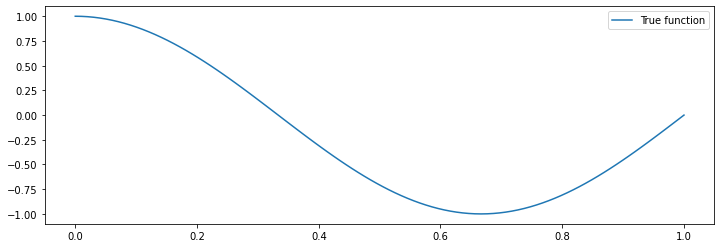

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.legend()

Let's now draw samples from a data distribution. We will generate random $x$, and then generate random $y$ using

$$ 
y = f(x) + \epsilon 
$$

for a random noise variable $\epsilon$.

In [5]:
n_samples = 30

X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1

We can visualize the samples.

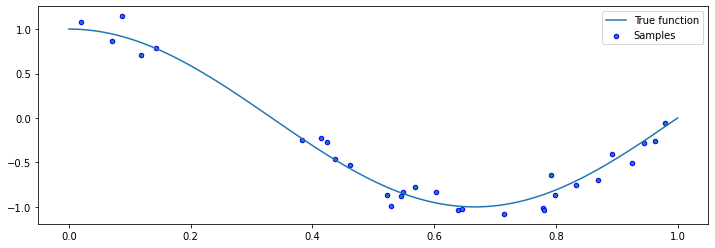

In [6]:
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.legend()

### 4.6.1.3. Data Distribution: Motivation

Why assume that the dataset is sampled from a distribution?

* The process we model may be effectively random. If $y$ is a stock price, there is randomness in the market that cannot be captured by a deterministic model.

* There may be noise and randomness in the data collection process itself (e.g., collecting readings from an imperfect thermometer).

* We can use probability and statistics to analyze supervised learning algorithms and derive their correctness from a small number of assumptions, like the IID assumption on the dataset.

### 4.6.1.4. KL Divergences and Maximum Likelihood

Maximizing likelihood is closely related to minimizing the Kullback-Leibler (KL) divergence $D(\cdot\|\cdot)$ between the model distribution and the data distribution.

$$
D(p \| q) = \sum_{{\bf x}} p({\bf x}) \log \frac{p({\bf x})}{q({\bf x})}.
$$

The KL divergence is always non-negative, and equals zero when $p$ and $q$ are identical. This makes it a natural measure of similarity that's useful for comparing distributions. 

Let $\hat{P}(x, y)$ denote the *empirical* distribution of the data:

$$
\hat{P}(x, y) = \begin{cases}
\frac{1}{n} & \text{if } (x,y) \in \mathcal{D} \\
0 & \text{otherwise.}
\end{cases}
$$

This distribution assigns a probability of $1/n$ to each of the data points in $\mathcal{D}$ (and zero to all the other possible $(x,y)$); it can be seen as a guess of the true data distribution from which the dataset $\mathcal{D}$ was obtained.

Selecting parameters $\theta$ by maximizing the likelihood is equivalent to selecting $\theta$ that minimizes the KL divergence between the empirical data distribution and the model distribution:

$$
\begin{align*}
\max_{\theta} \frac{1}{n} \sum_{i=1}^n \log P_\theta({x}^{(i)}, y^{(i)})
& = \max_{\theta} \mathbb{E}_{\hat{P}(x, y)} \left[ \log P_\theta(x,y) \right] \\
& = \min_{\theta} KL(\hat{P}(x,y) || P_\theta(x,y) ).
\end{align*}
$$

Here, $\mathbb{E}_{p(x)} f(x)$ denotes $\sum_{x \in \mathcal{X}} f(x) p(x)$ if $x$ is discrete and $\int_{x \in \mathcal{X}} f(x) p(x) dx$ if $x$ is continuous.

In other words, by maximizing the likelihood, we are choosing parameters $\theta$ such that the model distribution $P_\theta(x,y)$ is similar to the empirical data distribution, as measured by the KL divergence.

The same is true for conditional log-likelihood (homework problem!):

$$
\max_{\theta} \mathbb{E}_{\hat{P}(x, y)} \left[ \log P_\theta(y|x) \right] = \min_{\theta} \mathbb{E}_{\hat{P}(x)} \left[ KL(\hat{P}(y|x) || P_\theta(y|x) )\right].
$$

## 4.6.2. Maximum Likelihood Interpretation of OLS

Finally, we want to conclude this section with another application of the principle of maximum likelihood. We will show that the ordinary least squares algorithm from the previous lecture is also an instance of maximum likelihood learning underneath the hood.

This is also an advanced section that can be skipped at a first reading.

### 4.6.2.1. Recall: Ordinary Least Squares

Recall that in ordinary least squares (OLS), we have a linear model of the form

$$
f(x) = \sum_{j=0}^d \theta_j \cdot x_j = \theta^\top x.
$$

At each training instance $(x,y)$, we seek to minimize the squared error

$$
(y - \theta^\top x)^2.
$$

### 4.6.2.2. Maximum Likelihood Interpretation of OLS

Let's make our usual linear regression model probabilistic: assume that the targets and the inputs are related by

$$ y = \theta^\top x + \epsilon, $$

where $\epsilon \sim \mathcal{N}(0,\sigma^2)$ is a random noise term that follows a Gaussian (or "Normal") distribution.

The density of $\epsilon \sim \mathcal{N}(0,\sigma^2)$ is a Gaussian distribution:

$$ 
P(\epsilon; \sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{\epsilon^2}{2 \sigma^2} \right).
$$

This implies that

$$ 
P(y | x; \theta) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(y - \theta^\top x)^2}{2 \sigma^2} \right).
$$

This is a Gaussian distribution with mean $\mu_\theta(x) = \theta^\top x$ and variance $\sigma^2$. 
Given an input of $x$, this model outputs a "mini Bell curve" with width $\sigma$ around the mean $\mu(x) = \sigma^\top x$.

Let's now learn the parameters $\theta$ of 

$$ 
P(y | x; \theta) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(y - \theta^\top x)^2}{2 \sigma^2} \right)
$$

using maximum likelihood. 
The log-likelihood of this model at a point $(x,y)$ equals

$$
\begin{align*}
\log L(\theta) = \log p(y | x; \theta) = \text{const}_1 \cdot (y - \theta^\top x)^2 + \text{const}_2
\end{align*}
$$

for some constants $\text{const}_1, \text{const}_2$. But that's just the least squares objective!

Least squares thus amounts to fitting a Gaussian  probabilistic model $P(y|x) = \mathcal{N}(y; \mu(x), \sigma)$ with a standard deviation $\sigma$ of one and a mean of $\mu(x) = \theta^\top x$.

Note in particular that OLS implicitly makes the assumption that the noise is Gaussian around the mean. 
When that's not the case, you may want to also experiment with other kinds of models.